In [1]:
import csv
import ujson
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
from rapidfuzz import fuzz

In [2]:
# 파일 경로
original_path = "original_ner.json" # 원문으로부터 CyNER를 통해 추출한 Label
llm_qa_data_path_35 = "gpt_results_250427.json" # LLM을 통해 QA한 main NER Entity
llm_qa_data_path_4o = "gpt_results_2503.json"

# JSON 로드
with open(original_path, "r") as f:
    original_data = ujson.load(f)
with open(llm_qa_data_path_35, "r") as f:
    llm_qa_data_35 = ujson.load(f)
with open(llm_qa_data_path_4o, "r") as f:
    llm_qa_data_4o = ujson.load(f)

In [3]:
# NER 레이블 종류
LABELS = ["Malware", "System", "Indicator", "Vulnerability", "Organization"]

# id와 qa_text만 추출하는 딕셔너리 생성
id_to_qa_35 = {item["id"]: item["qa_text"] for item in llm_qa_data_35 if "id" in item and "qa_text" in item}
id_to_qa_4o = {item["id"]: item["qa_text"] for item in llm_qa_data_4o if "id" in item and "qa_text" in item}

processed_qa_35, processed_qa_4o = {}, {}

In [4]:
for id_, qa_str in id_to_qa_35.items():
    # 중괄호 제거, 양끝 공백 제거 후 ',' 기준으로 split
    items = qa_str.strip("{} ").split(',')
    # 각 항목에서 양끝 공백 제거
    items = [item.strip() for item in items if item.strip()]
    processed_qa_35[id_] = items

for id_, qa_str in id_to_qa_4o.items():
    # 중괄호 제거, 양끝 공백 제거 후',' 기준으로 split
    items = qa_str.strip("{} ").split(',')
    # 각 항목에서 양끝 공백 제거
    items = [item.strip() for item in items if item.strip()]
    processed_qa_4o[id_] = items

In [5]:
def parse_ner_string(ner_string, labels):
    """
    예시 입력: "{LockBit, no answer, FakeUpdates, Evil Corp}"
    출력: {label: entity or 'no answer'}
    """
    ner_string = ner_string.strip("{} ")
    elements = [element.strip() for element in ner_string.split(",")]

    # 길이 안 맞으면 그냥 패스 (데이터 불완전할 경우)
    if len(elements) != len(labels):
        return None

    return dict(zip(labels, elements))

In [6]:
def save_failed_predictions(processed_qa, original_ner_dict, output_path="failed_cases_general.csv"):
    with open(output_path, "w", newline='', encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["id", "label", "prediction", "gold_entities", "match"])

        for id_, pred_entities in processed_qa.items():
            ner_entry = original_ner_dict.get(str(id_))
            if not ner_entry:
                continue

            try:
                for idx, label in enumerate(LABELS):
                    if idx == 2:
                        # 현재 label이 indicator이면 vulnerability로 교체
                        pred = pred_entities[3]
                    elif idx == 3:
                        # 현재 label이 vulnerability면 indicator로 교체
                        pred = pred_entities[2]
                    else:
                        pred = pred_entities[idx]
                    gold_entities = set(map(str.lower, ner_entry.get(label, [])))

                    pred_set = set() if pred.lower() == "no answer" else {pred.lower()}
                    match = bool(pred_set & gold_entities)

                    if not match and gold_entities:
                        writer.writerow([id_, label, pred, list(gold_entities), match])
            except Exception as e:
                print(f"[SAVE-FAILED-PRED] 문서 번호 : {id_}, 오류 예측 QA : {pred_entities}")
                continue

In [7]:
def token_f1(pred, gold):
    pred_tokens = set(pred.lower().split())
    gold_tokens = set(gold.lower().split())

    tp = len(pred_tokens & gold_tokens)
    fp = len(pred_tokens - gold_tokens)
    fn = len(gold_tokens - pred_tokens)

    precision = tp / (tp + fp) if tp + fp else 0
    recall = tp / (tp + fn) if tp + fn else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall else 0

    return precision, recall, f1


In [40]:
# 예: processed_qa = {0: ['LockBit', 'no answer', ...], ...}
# 예: original_ner = ["0": {"System": [...], "Malware": [...], ...}, "1": {...}]
def evaluate_qa_vs_ner(processed_qa, original_ner_dict, doc_stats, llm_qa_data_path):
    y_true = defaultdict(list)
    y_pred = defaultdict(list)

    exact_match_counts = defaultdict(int)
    fuzzy_match_counts = defaultdict(int)
    token_f1_scores = defaultdict(list)
    total_counts = defaultdict(int)
    total_tp, total_fp, total_fn = 0,0,0

    for id_, pred_entities in processed_qa.items():
        ner_entry = original_ner_dict.get(str(id_))
        if not ner_entry:
            continue

        # doc_id 문서에서의 true, pred
        doc_y_true = []
        doc_y_pred = []

        try:
            for idx, label in enumerate(LABELS):
                if idx == 2:
                    pred = pred_entities[3]  # swap: Indicator ←→ Vulnerability
                elif idx == 3:
                    pred = pred_entities[2]
                else:
                    pred = pred_entities[idx]

                gold_entities = set(map(str.lower, ner_entry.get(label, []))) # 각 레이블마다 해당하는 정답 엔티티 리스트를 가져온다.
                pred = pred or ""
                pred_lower = pred.strip().lower()

                if pred_lower and pred_lower != "no answer":
                    pred_set = {pred_lower}
                else:
                    pred_set = set()

                match_exact = False
                match_fuzzy = False
                best_token_f1 = 0.0

                for gold in gold_entities:
                    if pred_lower == gold:
                        match_exact = True
                    if fuzz.ratio(pred_lower, gold) >= 85:
                        match_fuzzy = True
                    _, _, token_f1_score_val = token_f1(pred, gold)
                    best_token_f1 = max(best_token_f1, token_f1_score_val)

                # Save binary match for P/R/F1 calc
                # 1. 정답 기준 평가 (Recall)
                for gold in gold_entities:
                    y_true[label].append(1)
                    y_pred[label].append(1 if gold in pred_set else 0)
                    doc_y_true.append(1)
                    doc_y_pred.append(1 if gold in pred_set else 0)
                    if gold not in pred_set:
                        total_fn += 1
                    else:
                        total_tp += 1

                # 2. 예측 기준 평가 (Precision - FP 반영)
                for pred_item in pred_set:
                    if pred_item not in gold_entities:
                        y_true[label].append(0)
                        y_pred[label].append(1)
                        doc_y_true.append(0)
                        doc_y_pred.append(1)
                        total_fp += 1

                # Save match metrics
                if match_exact:
                    exact_match_counts[label] += 1
                if match_fuzzy:
                    fuzzy_match_counts[label] += 1
                token_f1_scores[label].append(best_token_f1)
                total_counts[label] += 1

                precision, recall, f1, _ = precision_recall_fscore_support(
                    doc_y_true, doc_y_pred, average='binary', zero_division=0
                )


                doc_stats[id_] = {
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                }


        except Exception as e:
            print(f"[오류] 문서 번호: {id_}, 예측 QA: {pred_entities}, 에러: {e}")
            continue

    # 결과 출력
    print("Evaluation Results:")
    print(f"Original Articles : {len(original_data)}")
    print(f"LLM QA Articles   : {len(processed_qa)}\n")
    print(f"TOTAL TP:{total_tp}, FP:{total_fp}, FN:{total_fn}")

    label_precisions, label_recalls, label_f1s = [], [], []
    label_exact_rates, label_fuzzy_rates, label_tokenf1s = [], [], []

    for label in LABELS:
        p = precision_score(y_true[label], y_pred[label], zero_division=0)
        r = recall_score(y_true[label], y_pred[label], zero_division=0)
        f1 = f1_score(y_true[label], y_pred[label], zero_division=0)

        exact_rate = exact_match_counts[label] / total_counts[label] if total_counts[label] else 0
        fuzzy_rate = fuzzy_match_counts[label] / total_counts[label] if total_counts[label] else 0
        avg_tokenf1 = sum(token_f1_scores[label]) / len(token_f1_scores[label]) if token_f1_scores[label] else 0

        print(f"{label:15s} | P: {p:.4f} | R: {r:.4f} | F1: {f1:.4f} | EM: {exact_rate:.4f} | Fuzzy: {fuzzy_rate:.4f} | Tok-F1: {avg_tokenf1:.4f} | Count: {total_counts[label]}")

        label_precisions.append(p)
        label_recalls.append(r)
        label_f1s.append(f1)
        label_exact_rates.append(exact_rate)
        label_fuzzy_rates.append(fuzzy_rate)
        label_tokenf1s.append(avg_tokenf1)

    print(f"\n{'[전체 평균]':15s} | P: {sum(label_precisions)/len(LABELS):.4f} | R: {sum(label_recalls)/len(LABELS):.4f} | F1: {sum(label_f1s)/len(LABELS):.4f} | EM: {sum(label_exact_rates)/len(LABELS):.4f} | Fuzzy: {sum(label_fuzzy_rates)/len(LABELS):.4f} | Tok-F1: {sum(label_tokenf1s)/len(LABELS):.4f}")

    modelname = '4o' if "250427" in llm_qa_data_path else '35'
    return modelname, doc_stats

In [ ]:
doc_stats_4o, doc_stats_35 = {}, {}
modelname_4o, doc_stats_4o = evaluate_qa_vs_ner(processed_qa_4o, original_data, doc_stats_4o, llm_qa_data_4o)
modelname_35, doc_stats_35 = evaluate_qa_vs_ner(processed_qa_35, original_data, doc_stats_35, llm_qa_data_35)

[오류] 문서 번호: 325, 예측 QA: ['Answer 1 : ```BloodyStealer```\nAnswer 2 : ```Steam```\nAnswer 3 : ```no answer```\nAnswer 4 : ```cookies```\nAnswer 5 : ```Kaspersky```'], 에러: list index out of range
[오류] 문서 번호: 382, 예측 QA: ['Answer 1 : ```BloodyStealer```\nAnswer 2 : ```Steam```\nAnswer 3 : ```no answer```\nAnswer 4 : ```cookies```\nAnswer 5 : ```Kaspersky```'], 에러: list index out of range
[오류] 문서 번호: 1368, 예측 QA: ['Answer 1 : ```Ransomware```\nAnswer 2 : ```Industrial IoT```\nAnswer 3 : ```no answer```\nAnswer 4 : ```no answer```\nAnswer 5 : ```Forrester Research```'], 에러: list index out of range
[오류] 문서 번호: 3266, 예측 QA: ['Answer 1 : ```botnet```\nAnswer 2 : ```no answer```\nAnswer 3 : ```no answer```\nAnswer 4 : ```no answer```\nAnswer 5 : ```Department of Homeland Security```'], 에러: list index out of range
[오류] 문서 번호: 3275, 예측 QA: ['Answer 1 : ```botnets```\nAnswer 2 : ```no answer```\nAnswer 3 : ```no answer```\nAnswer 4 : ```no answer```\nAnswer 5 : ```Department of Homeland Security``

In [14]:
import pandas as pd
def init_dataframe_docs(doc_stats):
    df_doc = pd.DataFrame.from_dict(doc_stats, orient='index')
    df_doc.index.name = 'doc_id'
    df_doc.sort_index(inplace=True)
    return df_doc

In [15]:
df_doc_4o = init_dataframe_docs(doc_stats_4o)
df_doc_35 = init_dataframe_docs(doc_stats_35)

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def cdf_prec(df_doc_4o, df_doc_35, metric='precision'):
    plt.style.use('default')
    plt.figure(figsize=(7,5))

    prec_val_4o = df_doc_4o[metric].dropna().values
    sorted_prec_val_4o = np.sort(prec_val_4o)
    cdf = np.arange(1, len(sorted_prec_val_4o)+1) / len(sorted_prec_val_4o)
    plt.plot(sorted_prec_val_4o, cdf, label='gpt-4o-mini', color='green')

    prec_val_35 = df_doc_35[metric].dropna().values
    sorted_prec_val_35 = np.sort(prec_val_35)
    cdf = np.arange(1, len(sorted_prec_val_35)+1) / len(sorted_prec_val_35)
    plt.plot(sorted_prec_val_35, cdf, label='gpt-3.5-turbo', color='orange')

    # 화살표
    plt.annotate(
        text='better',
        xy=(0.75,0.35),
        xytext=(0.65,0.45),
        xycoords='axes fraction',
        textcoords='axes fraction',
        arrowprops=dict(arrowstyle='->', color='black', lw=2)
    )

    plt.xlabel("Score")
    plt.ylabel("Cumulative Probability")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()

    plt.savefig(f"figures/qa_{metric}_cdf.pdf")
    plt.show()


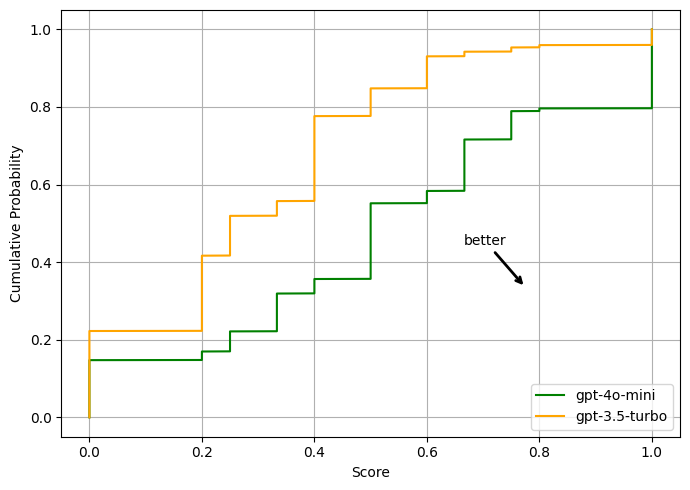

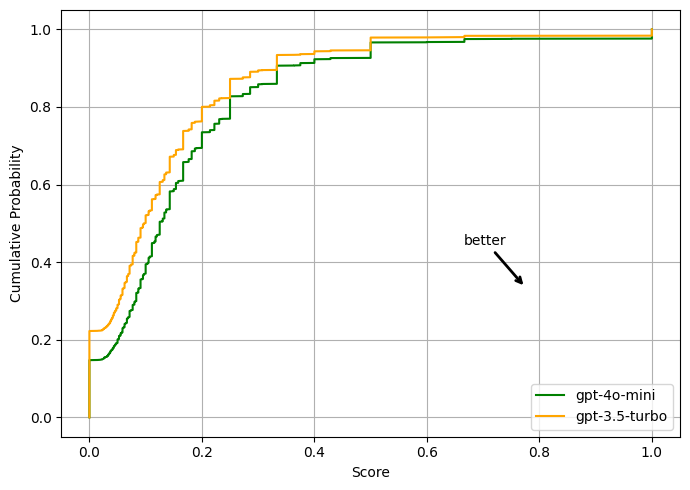

In [33]:
cdf_prec(df_doc_4o, df_doc_35, 'precision')
cdf_prec(df_doc_4o, df_doc_35, 'recall')